In [ ]:

from utils.plot import plot_metrics

base_dir = "/home/ubuntu/project/sentinel-2-ai-processor/src/results/2025-04-23_14-05-59/metrics"

In [139]:
df = pd.read_csv(f"{base_dir}/losses.csv")
df_sam = pd.read_csv(f"{base_dir}/sam_metrics.csv")
df_rmse = pd.read_csv(f"{base_dir}/rmse_metrics.csv")
df_psnr = pd.read_csv(f"{base_dir}/psnr_metrics.csv")

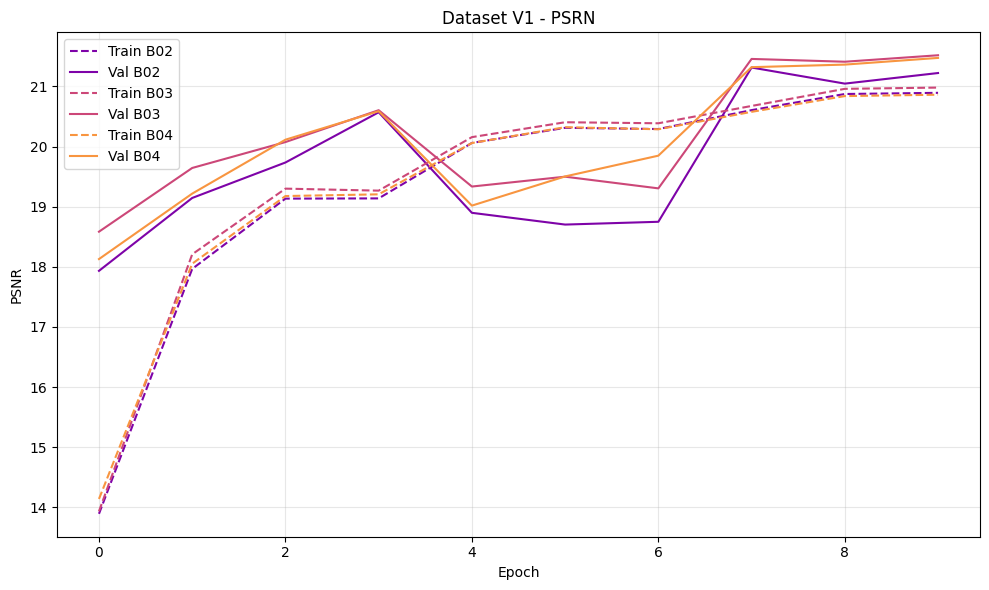

In [140]:
bands = ['B02', 'B03', 'B04']
plot_metrics(df_psnr, bands=bands, title="Dataset V1 - PSRN",
             log_scale=False,
             y_label="PSNR",
             verbose=True,
             save=False,
             save_path="ssim_metrics_plot.svg",
             color_palette="plasma")

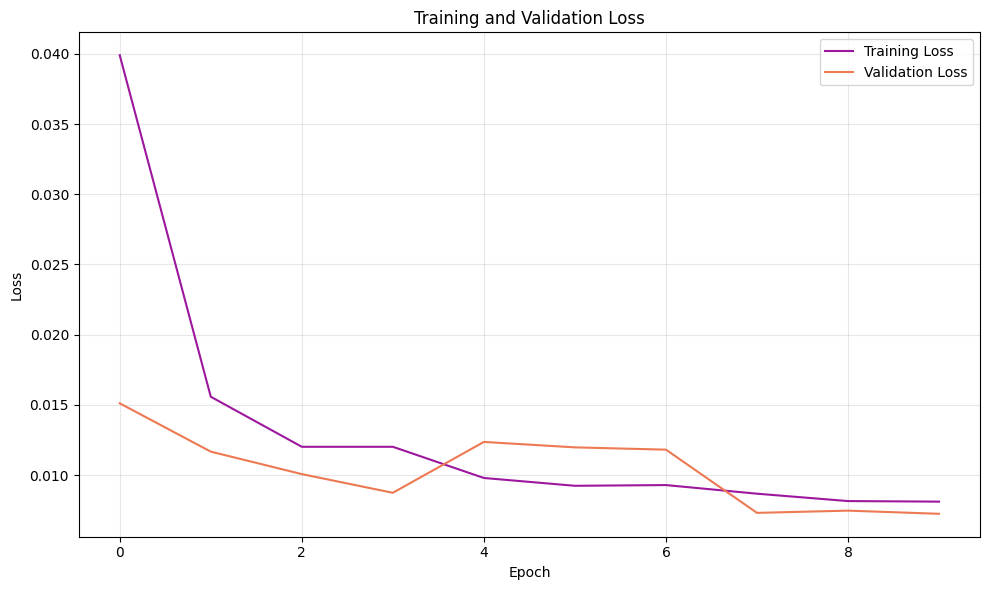

In [141]:
plot_training_loss(df=df,
                    title="Training and Validation Loss",
                    y_label="Loss",
                    log_scale=False,
                    verbose=True,
                    save=False,
                    save_path="loss_plot.svg",
                    color_palette="plasma")